In [63]:
!pip install torch==0.4.1

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [64]:
import copy
import itertools
from pprint import pprint

import torch
import luigi
import dill
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_context("talk")
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 140
mpl.rcParams['savefig.dpi'] = 160

from luigi_utils.helpers import load_completed_CCCs_into_dataframe
from empirical_privacy.row_distributed_svd import gen_SVD_CCCs_for_multiple_docs, \
svd_dataset_settings, ExpCCCSVD, CCCSVD, All
from dataset_utils.recsys_datasets import get_ml1m_user
from dataset_utils.text_datasets import get_twenty_doc

### First, focus on a specific dataset and problem setting

In [44]:
# CCCType = 'ExpCCCSVD' # Expectation
CCCType = 'CCCSVD' # KNN
CCCs = All(CCCType).requires()

In [45]:
len(CCCs)

6240

###### Load all results

In [46]:
DF = load_completed_CCCs_into_dataframe(CCCs)
n_docs = DF.doc_ind.nunique()
print(n_docs)
cp = sns.color_palette('hls', n_docs)

10


##### Pick one curve to model

In [47]:
subview = {
    'dataset_name': 'ml-1m',
    'doc_ind': 0,
    'part_fraction': 0.1
}
query = ' & '.join(['{k}=={v}'.format(k=k, v=v if type(v) is not str else '"'+v+'"') for k,v in subview.items()])
print(query)
DF = DF.query(query)
del DF['n_max']
del DF['n_trials_per_training_set_size']
DF.drop_duplicates(inplace=True)
DF.dropna(inplace=True)
print(DF.columns)
print(DF.shape)


dataset_name=="ml-1m" & doc_ind==0 & part_fraction==0.1
Index(['SVD_k', 'SVD_type', 'classifier_accuracy', 'dataset_name', 'doc_ind',
       'part_fraction', 'training_set_size', 'trial', 'validation_set_size'],
      dtype='object')
(298, 9)


In [48]:
for col in DF.columns:
    print(col)
    print(DF[col].unique()[0:11])

SVD_k
[14]
SVD_type
['hidden_eigs']
classifier_accuracy
[ 0.5         0.53125     0.47363281  0.49316406  0.48730469  0.53515625
  0.48925781  0.49414062  0.54882812  0.52246094  0.50585938]
dataset_name
['ml-1m']
doc_ind
[0]
part_fraction
[ 0.1]
training_set_size
[   8   16   32   64  128  256  512 1024 2048 4096 8192]
trial
[ 0  1  2  3  4  5  6  7  8  9 10]
validation_set_size
[1024]


In [97]:
DF[DF.training_set_size==4096]

,SVD_k,SVD_type,classifier_accuracy,dataset_name,doc_ind,part_fraction,training_set_size,trial,validation_set_size
550469,14,hidden_eigs,0.500977,ml-1m,0,0.1,4096,0,1024
550479,14,hidden_eigs,0.512695,ml-1m,0,0.1,4096,1,1024
550489,14,hidden_eigs,0.506836,ml-1m,0,0.1,4096,2,1024
550499,14,hidden_eigs,0.519531,ml-1m,0,0.1,4096,3,1024
550509,14,hidden_eigs,0.513672,ml-1m,0,0.1,4096,4,1024
551619,14,hidden_eigs,0.502930,ml-1m,0,0.1,4096,5,1024
552929,14,hidden_eigs,0.540039,ml-1m,0,0.1,4096,6,1024
554439,14,hidden_eigs,0.521484,ml-1m,0,0.1,4096,7,1024
556149,14,hidden_eigs,0.519531,ml-1m,0,0.1,4096,8,1024
558059,14,hidden_eigs,0.538086,ml-1m,0,0.1,4096,9,1024


In [50]:
DF[DF.training_set_size==8192]

,SVD_k,SVD_type,classifier_accuracy,dataset_name,doc_ind,part_fraction,training_set_size,trial,validation_set_size
593540,14,hidden_eigs,0.506836,ml-1m,0,0.1,8192,0,1024
593551,14,hidden_eigs,0.515625,ml-1m,0,0.1,8192,1,1024
593562,14,hidden_eigs,0.486328,ml-1m,0,0.1,8192,2,1024
593573,14,hidden_eigs,0.506836,ml-1m,0,0.1,8192,3,1024
593584,14,hidden_eigs,0.514648,ml-1m,0,0.1,8192,4,1024
594805,14,hidden_eigs,0.527344,ml-1m,0,0.1,8192,5,1024
596246,14,hidden_eigs,0.508789,ml-1m,0,0.1,8192,6,1024
597907,14,hidden_eigs,0.513672,ml-1m,0,0.1,8192,7,1024
599788,14,hidden_eigs,0.511719,ml-1m,0,0.1,8192,8,1024
601889,14,hidden_eigs,0.501953,ml-1m,0,0.1,8192,9,1024


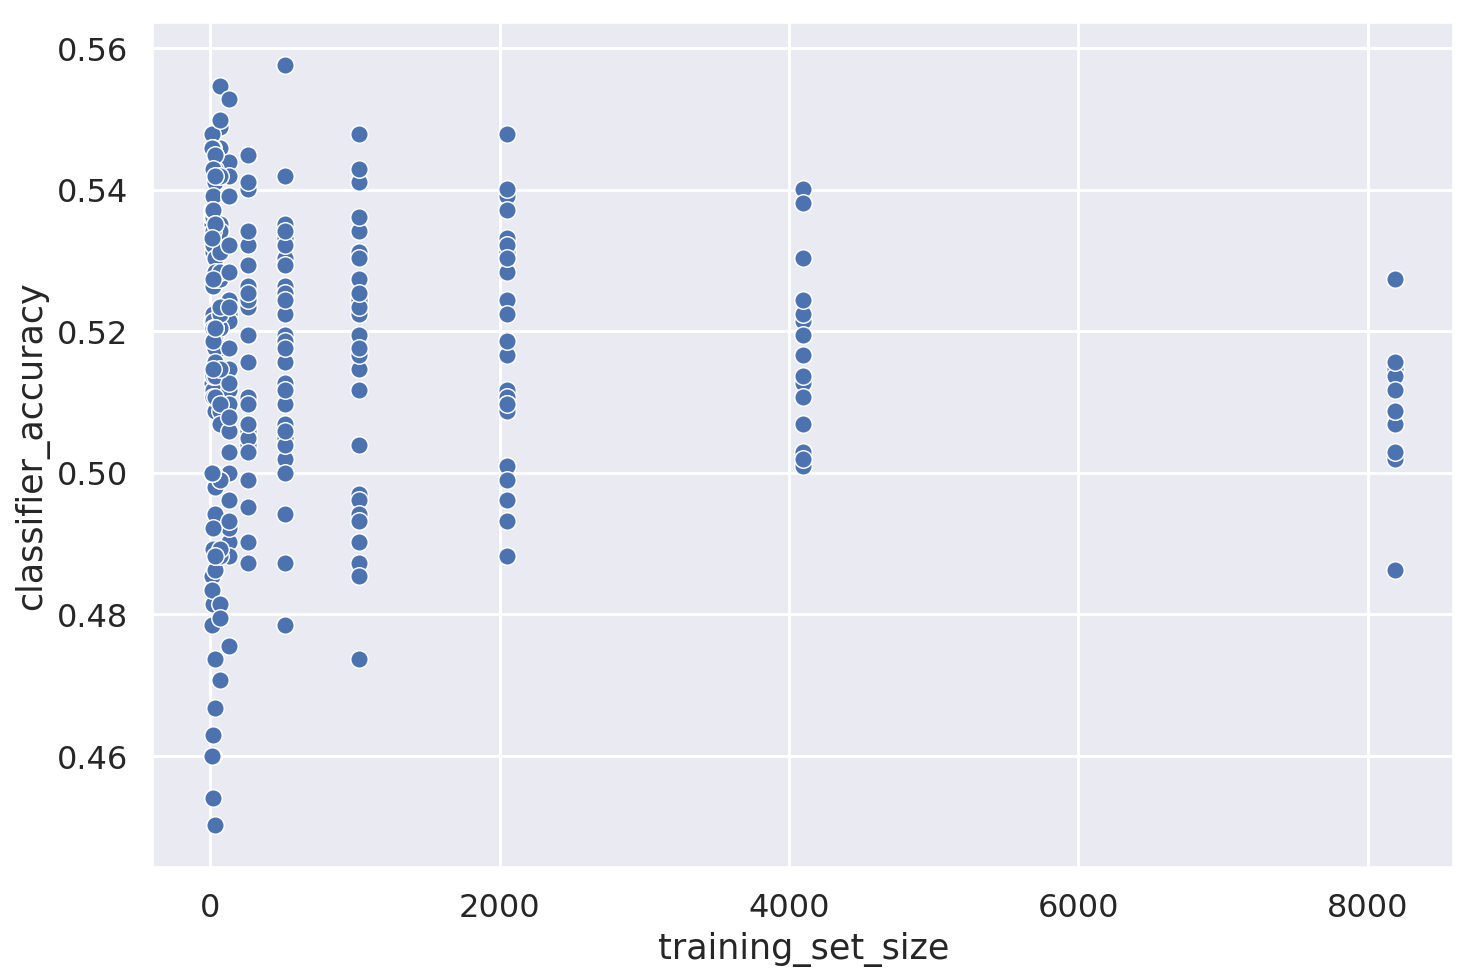

In [59]:
sns.scatterplot(x='training_set_size', y='classifier_accuracy', data=DF)

### Learning Torch

In [65]:
x = torch.rand(2,3)
print(x)

tensor([[0.8748, 0.6356, 0.5033],
        [0.1346, 0.5247, 0.8288]])


In [92]:
L = [range(i*3, i*3+3) for i in range(4)]
x = torch.tensor(L)
y = np.random.randn(4)
y_tensor = torch.from_numpy(y)
print(y_tensor.size())
print(y_tensor.numpy())


torch.Size([4])
[ 1.04722052  0.85583003  0.05882857  0.45575828]


In [93]:
print(torch.cuda.is_available())

False


### Applying torch to fit curve

In [118]:
x = DF.training_set_size.values.astype(np.double)
y = DF.classifier_accuracy.values
x = torch.from_numpy(x)
y = torch.from_numpy(y)
x.requires_grad=False
y.requires_grad=False

In [185]:
from torch.autograd import Variable

class KNNConvergenceCurve(torch.nn.Module):
    def __init__(self, x, y, d):
        super(KNNConvergenceCurve, self).__init__()
        self.m = torch.ones(1, requires_grad=True, dtype=torch.double)
        self.c = torch.ones(1, requires_grad=True, dtype=torch.double)
        self.x = x
        self.y = y
        self.d = d
    
    def predict(self, x):
        return self.m + self.c * 1/(x**(2/(self.d+2)))
    
    def loss(self, x):
        return (self.y - self.predict(x)).pow(2).sum()
    
    def fit(self, learning_rate=0.01, n_iter=500):
        for t in range(n_iter):
            loss = self.loss(self.x)
            loss.backward()
            with torch.no_grad():
                self.m -= learning_rate * self.m.grad
                self.c -= learning_rate * self.c.grad
                self.m.grad.zero_()
                self.c.grad.zero_()
                
    def fit_with_optimizer(self, 
                           learning_rate=0.01,
                           n_iter=500,
                           opt=torch.optim.Adam,
                           loss_fn=torch.nn.MSELoss(reduction='sum')):
        opt = opt([self.m, self.c], lr=learning_rate)
        for t in range(n_iter):
            y_pred = self.predict(x)
            loss = loss_fn(y_pred, self.y)
            if t%25==0:
                print(t, loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        
    
mod = KNNConvergenceCurve(x,y,6)
print(mod)
print(list(mod.parameters()))

KNNConvergenceCurve()
[]


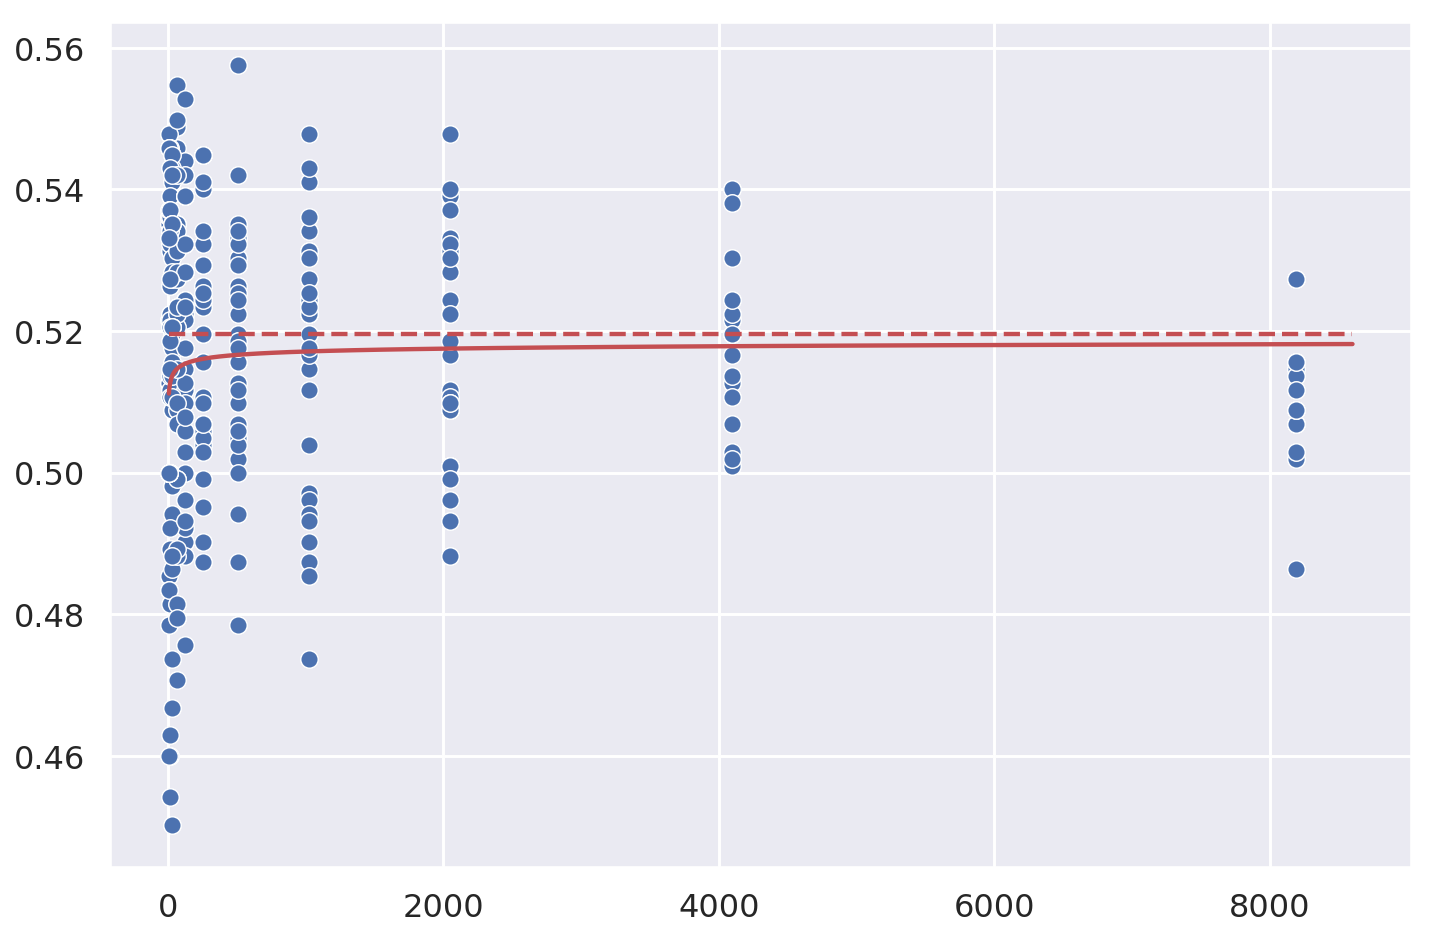

In [199]:
def plot_fit(mod):
    x = mod.x.numpy()
    y = mod.y.numpy()
    sns.scatterplot(x=x, y=y)
    N = np.logspace(np.log2(np.min(x)), np.log2(np.max(x)*1.05), base=2)
    plt.plot(N, mod.predict(torch.from_numpy(N)).detach().numpy(), '-r')
    plt.plot(N, np.ones_like(N)*mod.m.item(), '--r')
plot_fit(mod)

In [193]:
mod.fit_with_optimizer()

0 0.1138032705136825
25 0.1159467542718007
50 0.11391737585461464
75 0.11381703980682757
100 0.11380327461289419
125 0.11380328546410501
150 0.11380327191201252
175 0.1138032706805522
200 0.11380327052804334
225 0.11380327051386044
250 0.11380327051384245
275 0.11380327051369803
300 0.11380327051368332
325 0.11380327051368244
350 0.11380327051368246
375 0.11380327051368241
400 0.11380327051368237
425 0.11380327051368241
450 0.11380327051368243
475 0.11380327051368234


In [194]:
print(mod.m, mod.c)

tensor([0.5196], dtype=torch.float64, requires_grad=True) tensor([-0.0142], dtype=torch.float64, requires_grad=True)


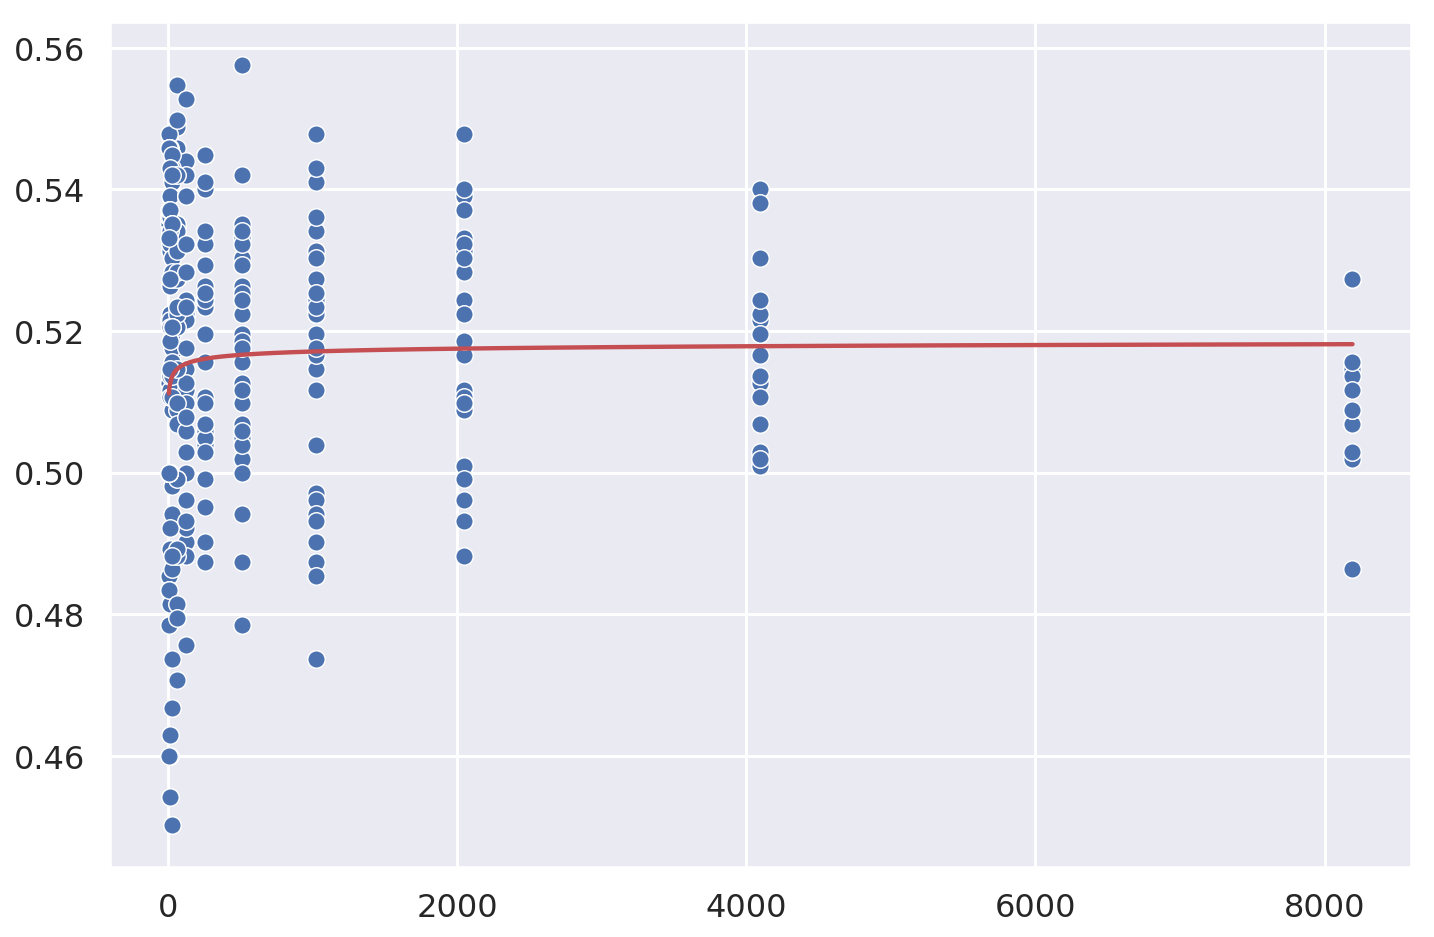

In [195]:
plot_fit(mod)